## Notebook for testing code

In [13]:
import geopandas as gpd
import pandas as pd

In [23]:
x=gpd.read_file('wdpa_southern.shp')

In [5]:
x['DESIG_ENG'].unique()

array(['Forest Reserve', 'World Heritage Site (natural or mixed)',
       'UNESCO-MAB Biosphere Reserve',
       'Ramsar Site, Wetland of International Importance',
       'Marine Protected Area', 'Communal Conservancy',
       'Community Forest', 'Concession', 'National Park',
       'Private Reserve', 'Special Nature Reserve',
       'Mountain Catchment Area', 'Nature Reserve',
       'Protected Environment', 'Forest Wilderness Area',
       'Forest Nature Reserve', 'Open area', 'Game Management Area',
       'Wildlife Sanctuary', 'Bird Sanctuary', 'Nature Forest Reserve',
       'Hunting Reserve', 'Community Conservation Area',
       'Ecological park', 'National Reserve', 'Sanctuary', 'Buffer Zone',
       'Special Reserve', 'Environmental Protection Area',
       'Recreation Park', 'Safari Area', 'Wildlife Reserve',
       'Game Reserve', 'Game Sanctuary',
       'Conservation and Development Area', 'State Forest'], dtype=object)

In [24]:
# unesco=x[x['DESIG_ENG']=='UNESCO-MAB Biosphere Reserve']
np=x[x['DESIG_ENG']=='National Park']
wh=x[x['DESIG_ENG']=='World Heritage Site (natural or mixed)']

In [25]:
df = pd.concat([np,wh]).reset_index(drop=True)

In [27]:
df.to_file('WDPA_southern.shp')

<AxesSubplot:>

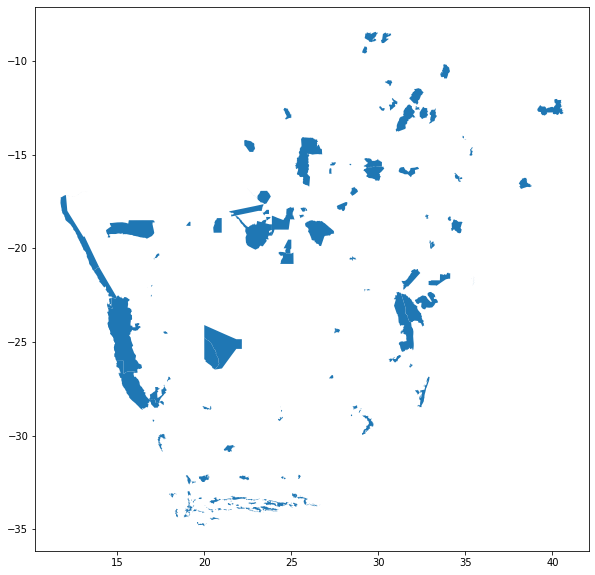

In [26]:
df.plot(figsize=(10,10))

In [ ]:
%matplotlib inline

import datacube
import numpy as np
import sys
import xarray as xr
from datacube.utils.dask import start_local_dask
import matplotlib.pyplot as plt

import dask
from odc.algo._dask import reshape_yxbt
import dask.array as da
from odc.algo import randomize, reshape_for_geomedian
from datacube.utils.geometry import assign_crs

from odc.algo import yxbt_sink
import hdstats

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_dask import create_local_dask_cluster
from deafrica_plotting import rgb
from datacube.testutils.io import rio_slurp_xarray
from odc.algo import xr_reproject
from odc.algo._dask import reshape_yxbt
import psutil

## define a function for calculating features

In [ ]:
import os
import numpy as np
import sys
import xarray as xr
from datacube.utils.geometry import assign_crs
from deafrica_bandindices import calculate_indices

In [ ]:
f1='/g/data/u23/data/tifs20/x+029/y-001/2019-01--P6M/'
f2='/g/data/u23/data/tifs20/x+029/y-001/2019-07--P6M/'

In [ ]:
rename_dict = {
        "B02": "blue",
        "B03": "green",
        "B04": "red",
        "B05": "red_edge_1",
        "B06": "red_edge_2",
        "B07": "red_edge_3",
        "B08": "nir",
        "B8A": "nir_narrow",
        "B11": "swir_1",
        "B12": "swir_2",
        "BCMAD": "bcdev",
        "EMAD": "edev",
        "SMAD": "sdev",
    }

#first 6 months
z=[]
files = os.listdir(f1)
files.sort()
for file in files[:-1]:
    if file.endswith(".tif"):
        x = assign_crs(xr.open_rasterio(f1+file).to_dataset(name=file[33:-4]))
        z.append(x)
        gm_s1 = xr.merge(z).squeeze()

gm_s1 = gm_s1.drop(['COUNT'])
gm_s1 = gm_s1.rename(rename_dict)
gm_s1 = gm_s1.drop(['nir_narrow'])

# second 6 months
z=[]
files = os.listdir(f2)
files.sort()
for file in files[:-1]:
    if file.endswith(".tif"):
        x = assign_crs(xr.open_rasterio(f2+file).to_dataset(name=file[33:-4]))
        z.append(x)
        gm_s2 = xr.merge(z).squeeze()

gm_s2 = gm_s2.drop(['COUNT'])
gm_s2 = gm_s2.rename(rename_dict)
gm_s2 = gm_s2.drop(['nir_narrow'])

In [ ]:
def gm_mads_two_seasons(ds1, ds2):
    """
    Feature layer function for production run of
    eastern crop-mask
    """            
    def fun(ds, era):
        #normalise SR and edev bands
        for band in ds.data_vars:
            if band not in ['sdev', 'bcdev']:
                ds[band] = ds[band] / 10000
                
        gm_mads = calculate_indices(ds,
                               index=['NDVI','LAI','MNDWI'],
                               drop=False,
                               normalise=False,
                               collection='s2')
        
        gm_mads['sdev'] = -np.log(gm_mads['sdev'])
        gm_mads['bcdev'] = -np.log(gm_mads['bcdev'])
        gm_mads['edev'] = -np.log(gm_mads['edev'])
        
        #rainfall climatology
        if era == '_S1':
            chirps = assign_crs(xr.open_rasterio('/g/data/CHIRPS/cumulative_alltime/CHPclim_jan_jun_cumulative_rainfall.nc'),  crs='epsg:4326')
        if era == '_S2':
            chirps = assign_crs(xr.open_rasterio('/g/data/CHIRPS/cumulative_alltime/CHPclim_jul_dec_cumulative_rainfall.nc'),  crs='epsg:4326')
        
        chirps = xr_reproject(chirps,ds.geobox,"bilinear")
        gm_mads['rain'] = chirps
        
        for band in gm_mads.data_vars:
            gm_mads = gm_mads.rename({band:band+era})
        
        return gm_mads
    
    epoch1 = fun(ds1, era='_S1')
    epoch2 = fun(ds2, era='_S2')
    
    #slope
    url_slope = "https://deafrica-data.s3.amazonaws.com/ancillary/dem-derivatives/cog_slope_africa.tif"
    slope = rio_slurp_xarray(url_slope, gbox=ds1.geobox)
    slope = slope.to_dataset(name='slope')
    
    result = xr.merge([epoch1,
                       epoch2,
                       slope],compat='override')
    
    result = result.astype(np.float32)
    return result.squeeze()

#call the function on the two 6-month gm+tmads
model_input = gm_mads_two_seasons(gm_s1, gm_s2)

In [ ]:
aa = gm_mads_two_seasons(gm_s1, gm_s2)

In [ ]:
aa.sdev_S1.plot(size=6)

## Compare jinjun's features with mine

In [ ]:
f1= "/g/data/u23/data/intermediate/pred_feature/data_x+040y+012_20210214_100816.nc"
f2= "/g/data/crop_mask/eastern/classifications/gm_mads_two_seasons_20201215/input/Eastern_tile_G-8_inputs.nc"
td= "../eastern_cropmask/results/training_data/gm_mads_two_seasons_training_data_20201215.txt"
# pred='/g/data/u23/data/crop-mask/prediction/Eastern_tile_x+040y+012_predict_pixel_gm_mads_two_seasons_20210215_044922.tif'

In [ ]:
# load the column_names
with open(td, 'r') as file:
    header = file.readline()

column_names = header.split()[2:]
print(len(column_names))
print(column_names)

In [ ]:
jj = xr.open_dataset(f1)
jj = jj[column_names]

In [ ]:
aa = xr.open_dataset(f2)
aa = xr_reproject(aa, jj.geobox)

In [ ]:
training_features == column_names

In [ ]:
def modify_ds(ds, variables):
    #grab SR and edev band and divide by 10000
    exclude = variables[10:12]+variables[26:28]+variables[12:15]+variables[28:31]+['slope', 'rain_S2','rain_S1']
    for band in ds.data_vars:
        if band not in exclude:
            print(band)
            ds[band] = ds[band] / 10000

    #log transform tmads
    ds['sdev_S1'] = -np.log(ds['sdev_S1'])
    ds['bcdev_S1'] = -np.log(ds['bcdev_S1'])
    ds['edev_S1'] = -np.log(ds['edev_S1'])
    ds['sdev_S2'] = -np.log(ds['sdev_S2'])
    ds['bcdev_S2'] = -np.log(ds['bcdev_S2'])
    ds['edev_S2'] = -np.log(ds['edev_S2'])

    #fix LAI
    ds['LAI_S1'] = (3.618 * ((2.5 * (ds.nir_S1 - ds.red_S1)) / (ds.nir_S1 + 6 * ds.red_S1 - 7.5 * ds.blue_S1 + 1)) - 0.118)
    ds['LAI_S2'] = (3.618 * ((2.5 * (ds.nir_S2 - ds.red_S2)) / (ds.nir_S2 + 6 * ds.red_S2 - 7.5 * ds.blue_S2 + 1)) - 0.118)
    
    #fix NDVI
    ds['NDVI_S1'] = (ds.nir_S1 - ds.red_S1) / (ds.nir_S1 + ds.red_S1)
    ds['NDVI_S2'] = (ds.nir_S2 - ds.red_S2) / (ds.nir_S2 + ds.red_S2)
    
    #fix MNDWI
    ds['MNDWI_S1'] = (ds.green_S1 - ds.swir_1_S1) /(ds.green_S1 + ds.swir_1_S1)
    ds['MNDWI_S2'] = (ds.green_S2 - ds.swir_1_S2) /(ds.green_S2 + ds.swir_1_S2)
    
    return ds

# model_input = modify_ds(model_input, training_features)

In [ ]:
jj = modify_ds(jj, column_names)

In [ ]:
aa.rain_S2.plot(size=5);

In [ ]:
jj.rain_S2.plot(size=5);

In [ ]:
rgb(aa, bands=['red_S1', 'green_S1', 'blue_S1'])

In [ ]:
rgb(jj, bands=['red_S1', 'green_S1', 'blue_S1'])

In [ ]:
# client = create_local_dask_cluster()
ncpu = psutil.cpu_count() - 2
client = start_local_dask(nanny=False,
                          n_workers=1, threads_per_worker=ncpu, mem_safety_margin='7G', # Generic
                          processes=False)
client

In [ ]:
dc = datacube.Datacube(app='stuff')

In [ ]:
# Define area of interest
lat = -3.0475
lon = 37.322
lon_buffer = 0.4
lat_buffer = 0.4

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

# Set the range of dates for the analysis
years_range = ('2019-01', '2019-12')

In [ ]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': years_range,
    'measurements': ['red','blue','green','nir','swir_1',
                     'swir_2','red_edge_1','red_edge_2','red_edge_3'],
    'resolution': (-10,10),
    'output_crs': 'epsg:6933',
    'group_by': 'solar_day'
}

# Load available data from Landsat 8
ds = load_ard(dc=dc,
              products=['s2_l2a'],
              **query,
#               dtype='native',
              dask_chunks={},
              scaling='normalised'
              )
ds

In [ ]:
def xr_geomedian_tmad(ds, axis='time', where=None, **kw):
    """
    :param ds: xr.Dataset|xr.DataArray|numpy array
    Other parameters:
    **kwargs -- passed on to pcm.gnmpcm
       maxiters   : int         1000
       eps        : float       0.0001
       num_threads: int| None   None
    """

    import hdstats
    def gm_tmad(arr, **kw):
        """
        arr: a high dimensional numpy array where the last dimension will be reduced. 
    
        returns: a numpy array with one less dimension than input.
        """
        gm = hdstats.nangeomedian_pcm(arr, **kw)
        return gm
        nt = kw.pop('num_threads', None)
        emad = hdstats.emad_pcm(arr, gm, num_threads=nt)[:,:, np.newaxis]
        smad = hdstats.smad_pcm(arr, gm, num_threads=nt)[:,:, np.newaxis]
        bcmad = hdstats.bcmad_pcm(arr, gm, num_threads=nt)[:,:, np.newaxis]
        return np.concatenate([gm, emad, smad, bcmad], axis=-1)


    def norm_input(ds, axis):
        if isinstance(ds, xr.Dataset):
            xx = reshape_yxbt(ds, yx_chunks=500)
            return ds, xx, xx.data
        else:  # assume numpy or similar
            xx_data = ds
            if xx_data.ndim != 4:
                raise ValueError("Expect 4 dimensions on input: y,x,band,time")
            return None, None, xx_data

    kw.setdefault('nocheck', False)
    kw.setdefault('num_threads', 1)
    kw.setdefault('eps', 1e-6)

    ds, xx, xx_data = norm_input(ds, axis)
    is_dask = dask.is_dask_collection(xx_data)

    if is_dask:
        if xx_data.shape[-2:] != xx_data.chunksize[-2:]:
            xx_data = xx_data.rechunk(xx_data.chunksize[:2] + (-1, -1))

        data = da.map_blocks(lambda x: gm_tmad(x, **kw),
                             xx_data,
                             name=randomize('geomedian'),
                             dtype=xx_data.dtype, 
                             chunks=xx_data.chunks[:-2] + (xx_data.chunks[-2][0]+3,),
                             drop_axis=3)
    else:
        data = gm_tmad(xx_data, **kw)

    dims = xx.dims[:-1]
    cc = {k: xx.coords[k] for k in dims}
    cc[dims[-1]] = np.hstack([xx.coords[dims[-1]].values,['edev', 'sdev', 'bcdev']])
    xx_out = xr.DataArray(data, dims=dims, coords=cc)

    if ds is None:
        xx_out.attrs.update(xx.attrs)
        return xx_out

    ds_out = xx_out.to_dataset(dim='band')
    for b in ds.data_vars.keys():
        src, dst = ds[b], ds_out[b]
        dst.attrs.update(src.attrs)

    return assign_crs(ds_out, crs=ds.geobox.crs)

In [ ]:
old=xr_geomedian_tmad(ds) #{'x':1500, 'y':1500, 'time':1}

In [ ]:
%%time
old=old.compute()

In [ ]:
old
# old gm+tmads: 7min 51s
# old gm-only: 7min 20s

In [ ]:
def xr_geomedian_tmad_new(ds, axis='time', **kw):
    """
    :param ds: xr.Dataset|xr.DataArray|numpy array
    Other parameters:
    **kwargs -- passed on to pcm.gnmpcm
       maxiters   : int         1000
       eps        : float       0.0001
       num_threads: int| None   None
    """

    import hdstats
    def gm_tmad(arr, **kw):
        """
        arr: a high dimensional numpy array where the last dimension will be reduced. 
    
        returns: a numpy array with one less dimension than input.
        """
        gm = hdstats.nangeomedian_pcm(arr, **kw)
        return gm
        nt = kw.pop('num_threads', None)
        emad = hdstats.emad_pcm(arr, gm, num_threads=nt)[:,:, np.newaxis]
        smad = hdstats.smad_pcm(arr, gm, num_threads=nt)[:,:, np.newaxis]
        bcmad = hdstats.bcmad_pcm(arr, gm, num_threads=nt)[:,:, np.newaxis]
        return np.concatenate([gm, emad, smad, bcmad], axis=-1)


    def norm_input(ds):
        if isinstance(ds, xr.Dataset):
            xx = reshape_yxbt(ds, yx_chunks=500)
            return ds, xx, xx.data

    kw.setdefault('nocheck', False)
    kw.setdefault('num_threads', 1)
    kw.setdefault('eps', 1e-6)

    ds, xx, xx_data = norm_input(ds)
    is_dask = dask.is_dask_collection(xx_data)

    if is_dask:
        data = da.map_blocks(lambda x: gm_tmad(x, **kw),
                             xx_data,
                             name=randomize('geomedian'),
                             dtype=xx_data.dtype, 
                             chunks=xx_data.chunks[:-2] + (xx_data.chunks[-2][0]+3,),
                             drop_axis=3)
    
    dims = xx.dims[:-1]
    cc = {k: xx.coords[k] for k in dims}
    cc[dims[-1]] = np.hstack([xx.coords[dims[-1]].values,['edev', 'sdev', 'bcdev']])
    xx_out = xr.DataArray(data, dims=dims, coords=cc)

    if ds is None:
        xx_out.attrs.update(xx.attrs)
        return xx_out

    ds_out = xx_out.to_dataset(dim='band')
    for b in ds.data_vars.keys():
        src, dst = ds[b], ds_out[b]
        dst.attrs.update(src.attrs)

    return assign_crs(ds_out, crs=ds.geobox.crs)


In [ ]:
new=xr_geomedian_tmad_new(ds.chunk({'x':11000, 'y':11000, 'time':1}))

In [ ]:
%%time
new=new.compute()

In [ ]:
new
# new gm+tmads: 6min 35s
# new gm-only: 7min 57s

In [ ]:
# chunk=750, no persist 4min 30s
# chunk=750, persist 4min 21s
# chunk=500, persist 5min 48s

# no_dask = 3min 50s
# no_dask_sink = 2min 55s

# no-dask

In [ ]:
dask.config.config['distributed']['worker']['memory']

In [ ]:
def xr_geomedian_tmad_fast(ds, ncpu, client):
    """
    Fastest version of geomedian+TMADS.
    Dask is used to arrange data into yxbt order,
    openmp runs runs gm+tmads in parallel, but all
    data is stored in memory
    """

    
    def gm_tmad(arr, ncpu, **kw):
        """
        arr: a high dimensional numpy array where the last dimension will be reduced. 
    
        returns: a numpy array with one less dimension than input.
        """
        print('gm')
        gm = hdstats.nangeomedian_pcm(arr, maxiters=1000,
                                   eps=1e-4,
                                   nocheck=True, 
                                   nodata=0,
                                   num_threads=ncpu)
        print('tmads')
        emad = hdstats.emad_pcm(arr, gm, num_threads=ncpu)[:,:, np.newaxis]
        smad = hdstats.smad_pcm(arr, gm, num_threads=ncpu)[:,:, np.newaxis]
        bcmad = hdstats.bcmad_pcm(arr, gm, num_threads=ncpu)[:,:, np.newaxis]
        return np.concatenate([gm, emad, smad, bcmad], axis=-1)
    
    # reorder data into yxbt order using dask
    bands = list(dv.data for dv in ds.data_vars.values())
    xx_data = yxbt_sink(bands, client)
    
    # run the gm and tmads using hdstats 
    data = gm_tmad(xx_data, ncpu)

    # recreate xarray
    dims = ('y', 'x', 'band')
    cc = ds.geobox.xr_coords(with_crs=True)
    cc['band'] = list(ds.data_vars)
    cc[dims[-1]] = np.hstack([cc[dims[-1]], ['edev', 'sdev', 'bcdev']])
    xx_out = xr.DataArray(data, dims=dims, coords=cc)

    ds_out = xx_out.to_dataset(dim='band')
    for b in ds.data_vars.keys():
        src, dst = ds[b], ds_out[b]
        dst.attrs.update(src.attrs)

    return assign_crs(ds_out, crs=ds.geobox.crs)

In [ ]:
%%time
nodask=xr_geomedian_tmad_fast(ds, ncpu=ncpu, client=client)

In [ ]:
#nodask
# nodask gm+tmads 18mins 14s
# nodask gm-only 5min 43s
# nodask gm+tmads 18mins 14s hdstats1.8post1

In [ ]:
nodask['edev'] = -np.log(nodask['edev'])
nodask['sdev'] = -np.log(nodask['sdev'])
nodask['bcdev'] = -np.log(nodask['bcdev'])

In [ ]:
nodask

In [ ]:
rgb(nodask, size=15)

In [ ]:
rgb(nodask, size=15, bands=['edev', 'sdev', 'bcdev'])

## Outlier detection

In [ ]:
tif = '../Supplementary_data/Urban_index_comparison/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_12_10.tif'

In [ ]:
X = xr.open_rasterio(tif).squeeze().isel(x=range(10000,20000), y=range(10000,20000)).astype(np.uint8)

In [ ]:
X

In [ ]:
X.plot(size=12);

# ***

In [ ]:
url_slope = "https://deafrica-data.s3.amazonaws.com/ancillary/dem-derivatives/cog_slope_africa.tif"
slope = rio_slurp_xarray(url_slope, gbox=ds.geobox)
print('mean: '+str(slope.mean().values))
print('max: '+str(slope.max().values))
print('min: '+str(slope.min().values))
slope.plot.hist(bins=50)

In [ ]:
_50 = slope>50
_100 = slope>100
_25 = slope>25
_30 = slope>30
_35 = slope>35

In [ ]:
slope.plot(figsize=(10,10), vmax=50);

In [ ]:
_25.plot(figsize=(10,10));

In [ ]:
from datacube.utils.cog import write_cog
write_cog(_35.astype(float), 'slope_35.tif', overwrite=True)

In [ ]:
_35.plot(figsize=(20,20));

In [ ]:
_30.plot(figsize=(20,20));

In [ ]:
_50.plot(figsize=(8,8));

In [ ]:
slope.plot.hist(figsize=(10,10), bins=50)

In [ ]:
def date_of_median(da, year, sample_lat, sample_lon):
    """
    da = xr.DataArray
        Assuming an annual time-series
    year = str
        year of time-series in 'da'
    sample_lat = float
        latitude pixel coordinate
    sample_lon = float
        longitude pixel coordinate
    
    """
    
    #calculate medians for each month
    monthly_medians = da.groupby('time.month').median()
    
    months = [str(i) for i in range(1,13)]
    indexes = [i for i in range(0,12)]
    
    dates=[]
    values=[]
    for month, index in zip(months,indexes): 
        
        #select the month of interest from da
        m = da.sel(time=year+"-"+month)
        
        #find regions with all-NaN slices
        mask = m.isnull().all('time')
        
        #calculate distance each pixel has from median
        distance = m - monthly_medians.isel(month=index)
        
        #index of the absolute minimum distance
        distance = distance.fillna(float(distance.max() + 1))
        distance=xr.ufuncs.fabs(distance)
        idx = distance.idxmin(dim='time', skipna=True).where(~mask)
        value = distance.sel(time=idx, method='nearest')
        values.append(value)
        dates.append(idx)
    
    #join into dataarray along new dimension
    dates = xr.concat(dates, "date of median")
    dist_from_median = xr.concat(values, 'dist_from_monthly_median')
    
    #select pixel
    dates = dates.sel(x=sample_lon, y=sample_lat, method='nearest')
    dist_from_median = dist_from_median.sel(x=sample_lon, y=sample_lat, method='nearest')
    
    return dates, dist_from_median

In [ ]:
date_of_median, dist_from_median = date_of_median(ds.blue,
                                                  sample_lon=1929690.,
                                                  sample_lat=-4123870.,
                                                  year='2018')

In [ ]:
print(date_of_median)

In [ ]:
dist_from_median.plot()